In [57]:
WORKSPACE_PATH = 'workspace'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'

In [58]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import cv2


Lese Annotationen

In [59]:
import json

def json_read(data_path):
    with open(data_path, 'r') as data:
        data = json.load(data)
    return data

In [60]:
XML_NAME = '/instances_default.json'
DATA_PATH = ANNOTATION_PATH+'/original'+ XML_NAME
data = json_read(DATA_PATH)


Benenne Bilder im Verzeichnis images und in der Annotationsdatei um

In [61]:
import os

def rename_images(IMAGE_PATH):
    index=1
    img  = os.listdir(IMAGE_PATH)
    for i in img:
        new_name = f"{index:012d}"+'.jpeg'
        old_path = os.path.join(IMAGE_PATH, i)
        new_path = os.path.join(IMAGE_PATH, new_name)
        os.rename(old_path, new_path)
        index += 1

def rename_images_in_annotation():
    index=1
    for img in data['images']:
        new_name = f"{index:012d}"+'.jpeg'
        img['file_name'] = new_name 
        index += 1

rename_images(IMAGE_PATH+'/original')
rename_images_in_annotation()

with open(ANNOTATION_PATH+'/original' + XML_NAME, 'w') as destination_file:
    json.dump(data, destination_file, indent=2)  

Read Json

In [62]:
images = []
bounding_boxes = []
labels = []
image_height = 1920
image_width = 1080

for image in data['images']:
    one_image = []
    one_image.append(image['id'])
    one_image.append(image['file_name'])
    images.append(one_image)

for annotation in data['annotations']:
    one_box = []
    one_box.append(annotation['bbox'])
    #one_box.append(annotation['id'])
    #one_box.append(annotation['image_id'])
    bounding_boxes.append(one_box)

print(images)
print(bounding_boxes)


[[1, '000000000001.jpeg'], [2, '000000000002.jpeg'], [3, '000000000003.jpeg'], [4, '000000000004.jpeg'], [5, '000000000005.jpeg'], [6, '000000000006.jpeg'], [7, '000000000007.jpeg'], [8, '000000000008.jpeg'], [9, '000000000009.jpeg'], [10, '000000000010.jpeg'], [11, '000000000011.jpeg'], [12, '000000000012.jpeg'], [13, '000000000013.jpeg'], [14, '000000000014.jpeg'], [15, '000000000015.jpeg'], [16, '000000000016.jpeg'], [17, '000000000017.jpeg']]
[[[39.37, 366.56, 481.39, 304.52]], [[45.75, 429.5, 459.55, 41.3]], [[44.68, 472.77, 459.55, 41.3]], [[43.86, 518.93, 459.54, 41.3]], [[30.05, 669.42, 492.05, 296.7]], [[45.19, 703.01, 458.15, 44.2]], [[42.64, 749.76, 226.95, 41.65]], [[273.84, 751.46, 231.2, 39.95]], [[45.19, 794.81, 223.55, 40.8]], [[277.24, 811.81, 19.55, 22.95]], [[356.29, 812.66, 19.55, 22.95]], [[427.69, 811.81, 20.4, 22.95]], [[45.19, 839.01, 128.35, 44.2]], [[172.69, 838.16, 96.9, 46.75]], [[379.24, 842.41, 125.8, 43.35]], [[43.49, 892.56, 227.8, 41.65]], [[276.39, 890

Resize images and boxes

In [63]:
def resize_imgaes(input_path, output_path, height, width):
    image =  cv2.imread(input_path)
    resized_image = cv2.resize(image, (height, width))
    cv2.imwrite(output_path, resized_image)    

def resize_bounding_boxes_and_area(input_path,bounding_boxes, height, width):
    image =  cv2.imread(input_path)
    height_ratio = height / image.shape[0]
    width_ratio = width / image.shape[1]
    
    for box in bounding_boxes:
        resized_boxes = []
        resized_area = 0

        x = np.round(box[0]*width_ratio,2)
        y = np.round(box[1]*height_ratio,2)
        x_width = np.round(box[2]*width_ratio,2)
        y_height = np.round(box[3]*height_ratio,2)
        resized_boxes.append([x, y, x_width, y_height])

        resized_area = x_width * y_height

    return x, y, x_width, y_height, resized_area


Bildgröße zum resizen wählen und Verzeichnisse erstellen

In [64]:
import os

height = 224
width = 224
OUTPUT_PATH_IMAGES = IMAGE_PATH + '/' + str(height) + 'x' + str(width)
OUTPUTPATH_ANNOTATIONS = ANNOTATION_PATH + '/' + str(height) + 'x' + str(width)

os.makedirs(OUTPUT_PATH_IMAGES, exist_ok=True)
os.makedirs(OUTPUTPATH_ANNOTATIONS, exist_ok=True)

#Copy XML Doc in new ANNOTATIONPATH
with open(DATA_PATH, 'r') as source_file:
    data = json.load(source_file)
with open(OUTPUTPATH_ANNOTATIONS + XML_NAME, 'w') as destination_file:
    json.dump(data, destination_file, indent=2)    


Resize Bilder und Bboxen und schreibe diese in das neue Verzeichnis und die neue Datei

In [65]:
#Resize Images
for img in range(len(images)):
    resize_imgaes(IMAGE_PATH+'/original'+ '/' +images[img][1], OUTPUT_PATH_IMAGES+ '/' +images[img][1], height, width)


with open(OUTPUTPATH_ANNOTATIONS + XML_NAME, 'r') as json_data:
    data = json.load(json_data)


#Resize BBox and area
for i, annotation in enumerate(data['annotations']):
    calculate_resize = resize_bounding_boxes_and_area(IMAGE_PATH+'/original'+ '/' +images[0][1],bounding_boxes[i], height, width)
    new_box = calculate_resize[0],calculate_resize[1],calculate_resize[2],calculate_resize[3]
    new_area = calculate_resize[4]
    annotation['bbox'] = new_box
    annotation['area'] = new_area

#Change height/width
for image in data['images']:
    image['height']=height
    image['width']=width

with open(OUTPUTPATH_ANNOTATIONS + XML_NAME, 'w') as destination_file:
    json.dump(data, destination_file, indent=2)    

Erstelle Labelmap

In [66]:
labels = [
{"id":1,"name":"Ausbildung","supercategory":""},{"id":2,"name":"Ausbildung_Staette","supercategory":""},{"id":3,"name":"Ausbildung_Klasse","supercategory":""},{"id":4,"name":"Ausbilung_Abschluss","supercategory":""},{"id":5,"name":"Ausbildung_Vollzeit","supercategory":""},{"id":6,"name":"Ausbildung_Teilzeit","supercategory":""},{"id":7,"name":"Ausbildung_Antrag_gestellt_ja","supercategory":""},{"id":8,"name":"Ausbildung_Antrag_gestellt_nein","supercategory":""},{"id":9,"name":"Ausbildung_Amt","supercategory":""},{"id":10,"name":"Ausbildung_Foerderungsnummer","supercategory":""},{"id":11,"name":"Person","supercategory":""},{"id":12,"name":"Person_Name","supercategory":""},{"id":13,"name":"Person_Vorname","supercategory":""},{"id":14,"name":"Person_Geburtsname","supercategory":""},{"id":15,"name":"Person_Geburtsort","supercategory":""},{"id":16,"name":"Person_weiblich","supercategory":""},{"id":17,"name":"Person_maennlich","supercategory":""},{"id":18,"name":"Person_divers","supercategory":""},{"id":19,"name":"Person_Geburtsdatum","supercategory":""},{"id":20,"name":"Person_Familienstand","supercategory":""},{"id":21,"name":"Person_Familienstand_seit","supercategory":""},{"id":22,"name":"Person_Stattsangehörigkeit_eigene","supercategory":""},{"id":23,"name":"Person_Stattsangehörigkeit_Ehegatte","supercategory":""},{"id":24,"name":"Person_Kinder","supercategory":""},{"id":25,"name":"Wohnsitz","supercategory":""},{"id":26,"name":"Wohnsitz_Strasse","supercategory":""},{"id":27,"name":"Wohnsitz_Hausnummer","supercategory":""},{"id":28,"name":"Wohnsitz_Adresszusatz","supercategory":""},{"id":29,"name":"Wohnsitz_Land","supercategory":""},{"id":30,"name":"Wohnsitz_Postleitzahl","supercategory":""},{"id":31,"name":"Wohnsitz_Ort","supercategory":""},{"id":32,"name":"Wohnsitz_waehrend_Ausbildung","supercategory":""},{"id":33,"name":"Wohnsitz_waehrend_Ausbildung_Strasse","supercategory":""},{"id":34,"name":"Wohnsitz_waehrend_Ausbildung_Hausnummer","supercategory":""},{"id":35,"name":"Wohnsitz_waehrend_Ausbildung_Adresszusatz","supercategory":""},{"id":36,"name":"Wohnsitz_waehrend_Ausbildung_Land","supercategory":""},{"id":37,"name":"Wohnsitz_waehrend_Ausbildung_Postleitzahl","supercategory":""},{"id":38,"name":"Wohnsitz_waehrend_Ausbildung_Ort","supercategory":""},{"id":39,"name":"Wohnsitz_waehrend_Ausbildung_elternwohnung_ja","supercategory":""},{"id":40,"name":"Wohnsitz_waehrend_Ausbildung_elternwohnung_nein","supercategory":""},{"id":41,"name":"Wohnsitz_waehrend_Ausbildung_elternmiete","supercategory":""},{"id":42,"name":"Wohnsitz_waehrend_Ausbildung_elternmiete_nein","supercategory":""}    ]

with open(ANNOTATION_PATH + '\label_map.pbtxt', 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

LABEL_MAP_PATH = ANNOTATION_PATH + '\label_map.pbtxt'

Erstelle TFRecords

In [67]:
import pprint
RECORDS_DATA_PATH = OUTPUTPATH_ANNOTATIONS + XML_NAME

with open(RECORDS_DATA_PATH, "r") as f:
    annotations = json.load(f)["annotations"]

print(f"Number of Boxes: {len(annotations)}")
pprint.pprint(annotations[8])

num_samples = 1#4096
num_tfrecords = len(annotations) // num_samples
if len(annotations) % num_samples:
    num_tfrecords += 1  # add one record if there are any remaining samples


Number of Boxes: 698
{'area': 436.18800000000005,
 'attributes': {'Geburtsort': '',
                'keyframe': True,
                'occluded': False,
                'rotation': 0.0,
                'track_id': 4},
 'bbox': [13.18, 130.33, 65.2, 6.69],
 'category_id': 15,
 'id': 9,
 'image_id': 1,
 'iscrowd': 0,
 'segmentation': []}


TFRecords Hilfsfunktionen

In [68]:
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()])
    )


def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))


def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def float_feature_list(value):
    """Returns a list of float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def create_example(image, path, example):
    feature = {
        "image": image_feature(image),
        "path": bytes_feature(path),
        "area": float_feature(example["area"]),
        "bbox": float_feature_list(example["bbox"]),
        "category_id": int64_feature(example["category_id"]),
        "id": int64_feature(example["id"]),
        "image_id": int64_feature(example["image_id"]),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "area": tf.io.FixedLenFeature([], tf.float32),
        "bbox": tf.io.VarLenFeature(tf.float32),
        "category_id": tf.io.FixedLenFeature([], tf.int64),
        "id": tf.io.FixedLenFeature([], tf.int64),
        "image_id": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    example["bbox"] = tf.sparse.to_dense(example["bbox"])
    return example


Generierung TFRecords

In [69]:
tfrecords_dir = OUTPUTPATH_ANNOTATIONS
images_dir = OUTPUT_PATH_IMAGES

split_ratio = 0.8

num_samples = len(annotations)
print(len(annotations))

num_train_samples = int(split_ratio * num_samples)
num_test_samples = num_samples - num_train_samples

np.random.shuffle(annotations)

train_samples = annotations[:num_train_samples]
test_samples = annotations[num_train_samples:]

#Train
with tf.io.TFRecordWriter(tfrecords_dir + "/train.tfrec") as writer:
    for sample in train_samples:
        image_path = f"{images_dir}/{sample['image_id']:012d}.jpeg"
        image = tf.io.decode_jpeg(tf.io.read_file(image_path))
        example = create_example(image, image_path, sample)
        writer.write(example.SerializeToString())
#Test
with tf.io.TFRecordWriter(tfrecords_dir + "/test.tfrec") as writer:
    for sample in test_samples:
        image_path = f"{images_dir}/{sample['image_id']:012d}.jpeg"
        image = tf.io.decode_jpeg(tf.io.read_file(image_path))
        example = create_example(image, image_path, sample)
        writer.write(example.SerializeToString())


698


TFRecord Beispiel

bbox: [109.99  93.52   5.01   2.9 ]
area: 14.529000282287598
category_id: 7
id: 198
image_id: 5
path: b'workspace/images/224x224/000000000005.jpeg'
Image shape: (224, 224, 3)


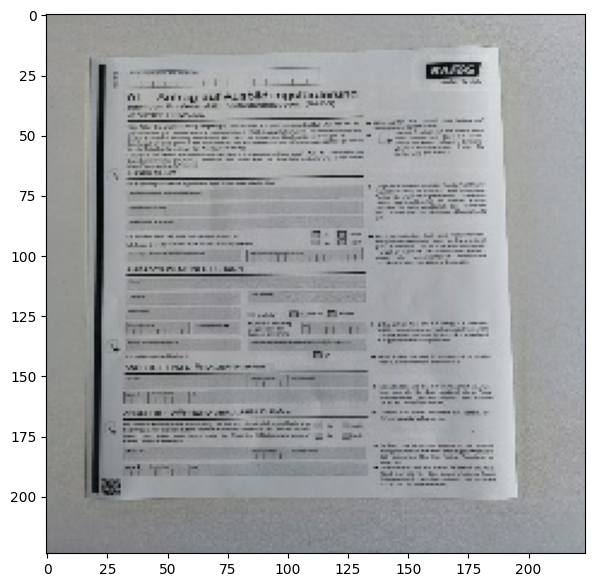

In [70]:
raw_dataset = tf.data.TFRecordDataset(f"{tfrecords_dir}/train.tfrec")
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)

for features in parsed_dataset.take(1):
    for key in features.keys():
        if key != "image":
            print(f"{key}: {features[key]}")

    print(f"Image shape: {features['image'].shape}")
    plt.figure(figsize=(7, 7))
    plt.imshow(features["image"].numpy())
    plt.show()


In [71]:
def prepare_sample(features):
    image = tf.image.resize(features["image"], size=(224, 224))
    return image, features["category_id"]

def get_dataset(filenames, batch_size):
    dataset = (
        tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
        .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
        .map(prepare_sample, num_parallel_calls=AUTOTUNE)
        .shuffle(batch_size * 10)
        .batch(batch_size)
        .prefetch(AUTOTUNE)
    )
    return dataset

train_filenames = tf.io.gfile.glob(f"{tfrecords_dir}/*train.tfrec")
test_filenames = tf.io.gfile.glob(f"{tfrecords_dir}/*test.tfrec")

batch_size = 2
epochs = 20
steps_per_epoch = 7
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = get_dataset(train_filenames, batch_size)
test_dataset = get_dataset(test_filenames, batch_size)

input_tensor = tf.keras.layers.Input(shape=(224, 224, 3), name="image")
model = tf.keras.applications.EfficientNetB0(
    input_tensor=input_tensor, weights=None, classes=91
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    verbose=1,
)

print(history.history)

Epoch 1/20
7/7 [==============================] - 27s 819ms/step - loss: 4.9008 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 4.5342 - val_sparse_categorical_accuracy: 0.0071
Epoch 2/20
7/7 [==============================] - 3s 523ms/step - loss: 5.2621 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 4.5593 - val_sparse_categorical_accuracy: 0.0143
Epoch 3/20
7/7 [==============================] - 3s 521ms/step - loss: 5.3415 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 4.4454 - val_sparse_categorical_accuracy: 0.0143
Epoch 4/20
7/7 [==============================] - 3s 536ms/step - loss: 5.3503 - sparse_categorical_accuracy: 0.0000e+00 - val_loss: 4.3376 - val_sparse_categorical_accuracy: 0.0286
Epoch 5/20
7/7 [==============================] - 3s 547ms/step - loss: 4.6744 - sparse_categorical_accuracy: 0.0714 - val_loss: 4.4093 - val_sparse_categorical_accuracy: 0.0071
Epoch 6/20
7/7 [==============================] - 3s 548ms/step - loss: 5.1553 - sparse_categ

In [75]:
label_map_path = LABEL_MAP_PATH

def read_label_map(label_map_path):

    item_id = None
    item_name = None
    items = {}

    with open(label_map_path, "r") as file:
        for line in file:
            line.replace(" ", "")
            if line == "item{":
                pass
            elif line == "}":
                pass
            elif "id" in line:
                item_id = int(line.split(":", 1)[1].strip())
            elif "name" in line:
                item_name = line.split(" ")[-1].replace("\"", " ").strip()
            if item_id is not None and item_name is not None:
                items[item_id] = item_name
                item_id = None
                item_name = None

    return items

label_map = read_label_map(label_map_path)
print(label_map)

{1: "name:'Ausbildung'", 2: "name:'Ausbildung_Staette'", 3: "name:'Ausbildung_Klasse'", 4: "name:'Ausbilung_Abschluss'", 5: "name:'Ausbildung_Vollzeit'", 6: "name:'Ausbildung_Teilzeit'", 7: "name:'Ausbildung_Antrag_gestellt_ja'", 8: "name:'Ausbildung_Antrag_gestellt_nein'", 9: "name:'Ausbildung_Amt'", 10: "name:'Ausbildung_Foerderungsnummer'", 11: "name:'Person'", 12: "name:'Person_Name'", 13: "name:'Person_Vorname'", 14: "name:'Person_Geburtsname'", 15: "name:'Person_Geburtsort'", 16: "name:'Person_weiblich'", 17: "name:'Person_maennlich'", 18: "name:'Person_divers'", 19: "name:'Person_Geburtsdatum'", 20: "name:'Person_Familienstand'", 21: "name:'Person_Familienstand_seit'", 22: "name:'Person_Stattsangehörigkeit_eigene'", 23: "name:'Person_Stattsangehörigkeit_Ehegatte'", 24: "name:'Person_Kinder'", 25: "name:'Wohnsitz'", 26: "name:'Wohnsitz_Strasse'", 27: "name:'Wohnsitz_Hausnummer'", 28: "name:'Wohnsitz_Adresszusatz'", 29: "name:'Wohnsitz_Land'", 30: "name:'Wohnsitz_Postleitzahl'", 3

In [80]:
image_path = '/000000000001.jpeg'
image = cv2.imread(OUTPUT_PATH_IMAGES + image_path)

predictions = model.predict(np.expand_dims(image, axis=0))
boxes = predictions[..., :4]
class_probs = predictions[..., 4:]

max_prob_index = np.argmax(class_probs)
predicted_class_id = max_prob_index + 1  #start bei index 1

predicted_class_name = label_map.get(predicted_class_id, "Unbekannte Klasse")

print("Vorhergesagte Klasse:", predicted_class_name)
print(boxes)


1/1 [==============================] - 0s 43ms/step
Vorhergesagte Klasse: name:'Person_Geburtsname'
[[0.00106777 0.00052491 0.00344007 0.06666254]]
